In [2]:
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 01 Basic intuition of deriviates

In [3]:
# basic function to illustrate
def f(x):
    return 3*x**2 -4*x + 5

In [4]:
f(3.0)

20.0

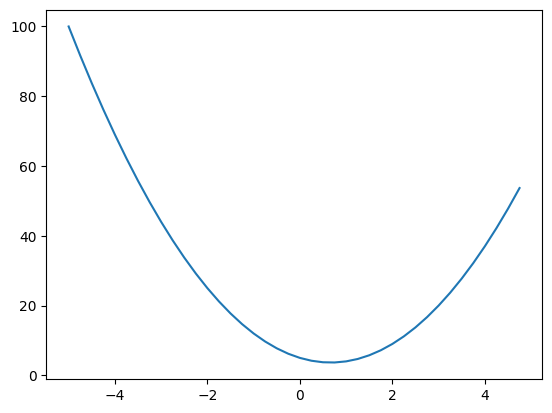

In [5]:
# now we construct x and y values to plot a graph of the function
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

## Recall derivate defnition
Instead of calculating the derivate with rules (chain rule etc), in neural nets we look at the definition:
$$L = lim_{h->0} \frac{f(x+h) - f(x)}{h}$$

We can simulate this easily with the following code

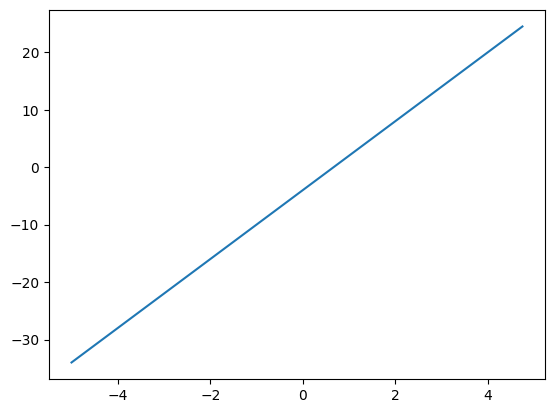

In [6]:
h = 0.001
xs_ = xs + h
ys_ = f(xs_)
der = (ys_ - ys) /h
plt.plot(xs, der)


Lets do a check by calculating the derivative function of f. This would be 6x-4
So the derivative at 3 would be 14. Let's check this for our approximation

In [7]:
der[np.where(xs==3.)].item()

14.00300000000243

In [8]:
# lets get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b +c
print(d)

4.0


In [9]:
# more complex look at derivate with multiple variables, but derivitive in respect to only one
h = 0.0001
d1 = a*b + c
a += h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2 -d1)/h)


d1 4.0
d2 3.999699999999999
slope -3.000000000010772


## Moving to neural networks with our own data structure
Now that we have an intuitive understanding of derivatives, we build our own data structure to later apply this project on neural networks

In [10]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data}, {self.label})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [11]:
a = Value(2.0, label='a') #input data
b = Value(-3.0, label='b') # weight
c = Value(10.0, label='c') # bias
e = a*b; e.label = 'e' # first node
d = e + c; d.label = 'd' # sum of node and bias
f = Value(-2.0, label='f') # second weight
L = d * f; L.label = 'L' # next node without bias
L1 = L

### Visualize helper
to visualize our test example we need the following code:


In [12]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

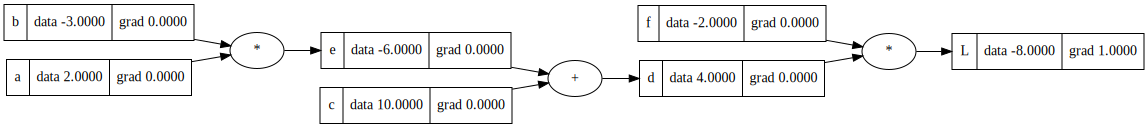

In [13]:
L.grad = 1.0 
draw_dot(L)

In [14]:
def lol():
    h = 0.0001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    print((L2-L1)/h)

In [15]:
lol()

6.000000000021544


Now we have different equtations that are chained together similar as in neural network. We no calculate the gradient of every variable according to the variable before
$$ dL/dd = f $$
$$ dL/df = d $$
### chain rule step:
$$ dL/dc = dL/dd * dd/dc
analogous for dL/de

$$ dL/da = dL/de * de/da $$
$$ dL/db = dL/de * de/db

In [16]:
d.grad = -2.0 # f.value
f.grad = 4.0 # 10 (c value) + 2.0 * -3.0 (a*b (e value))
c.grad = -2.0 * 1 # dL/dd * dL/dc
e.grad = -2.0 # analogous to c.grad
a.grad = -2.0 * -3.0 # e.grad * b (derivate von de/da)
b.grad = -2.0 * 2.0 # e.grad * a



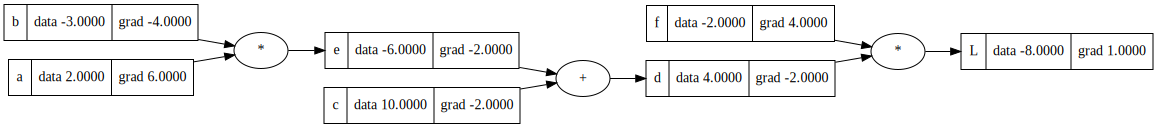

In [17]:
draw_dot(L)

### Make it more like a neural network
Instead of using random variables name, we try to mimic the conventions of a neural net and also add an activation function


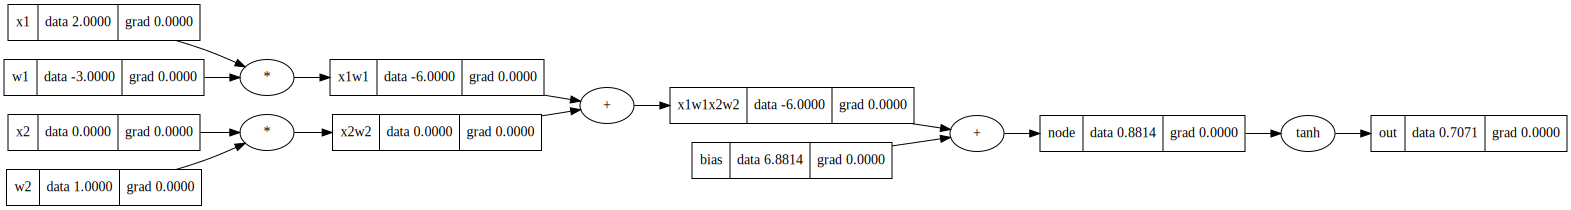

In [18]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
bias = Value(6.88137358, label='bias')
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label='x2w2' 
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
node = x1w1x2w2 + bias; node.label='node'
out = node.tanh(); out.label='out'
draw_dot(out)

In [19]:
out = node.tanh()
out

Value(data=0.707106777676776, )

Now we do the manual backpropagation excercise once again to really be sure we got this. Let's go!

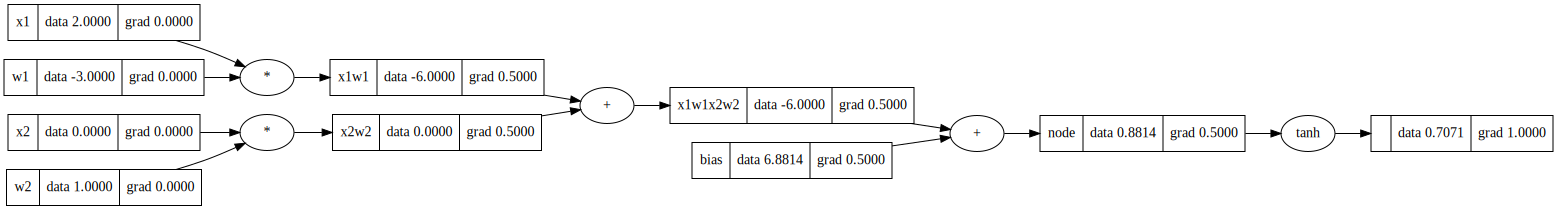

In [20]:
# base case
out.grad=1.0
# gradient of node
# dout/dnode
# 1 - tanh(node)**2
node.grad = 1- (out.data)**2 # since tanh(node) is out by definition

# dout/dbias = dout/dnode * dnode/dbias
# = node.grad * dnode/dbias
# this is a constant so:
bias.grad = node.grad * 1
# same for x1w1x2w2
x1w1x2w2.grad = node.grad * 1
# next we have dout/dx1w1 = dout/dnode * dnode/d/x1w1x2w2 * dx1w1x2w2/dx2w2
# we have sums again, so we just take the known gradient by 1
x2w2.grad = x1w1x2w2.grad * 1
# same for dout/dx1w1
x1w1.grad = x1w1x2w2.grad * 1
# draw in between for overview
draw_dot(out)

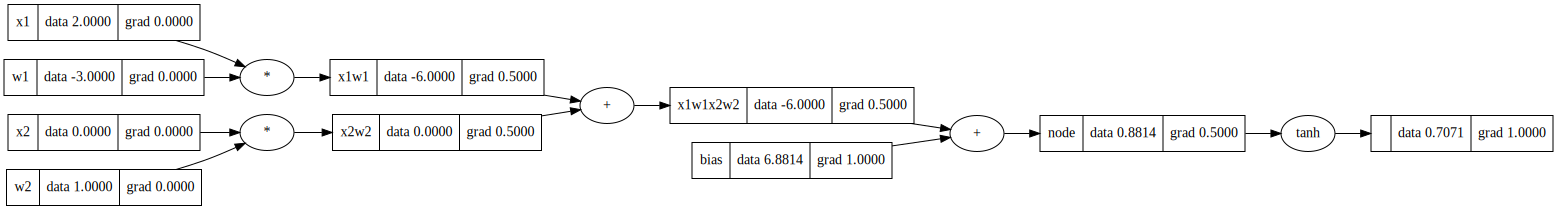

In [21]:
bias.grad = 1
draw_dot(out)

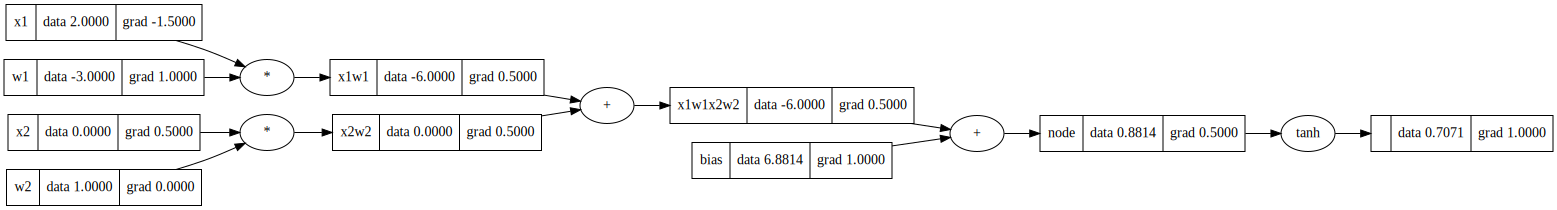

In [22]:
# from before we already know how calc the gradient for mulitplication layers, so:
# dout/dw1 = <gradient from before> * dx1w1/dw1 (=x1)
w1.grad = x1.data * x1w1.grad
# same for other nodes:
x1.grad = w1.data * x1w1.grad
w2.grad = x2.data * x2w2.grad
x2.grad = w2.data * x2w2.grad
draw_dot(out)

### using the now implemented backward methods from our value function.
in the last step we manually calculated the gradient, now we set evertything to zero and use the backward method to do this

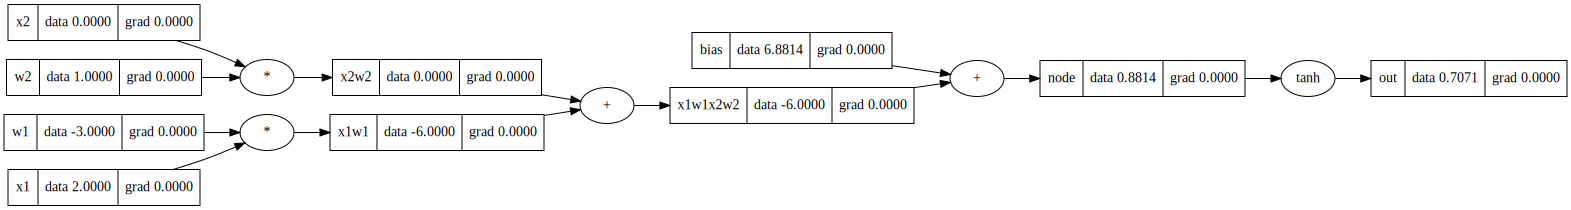

In [23]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
bias = Value(6.88137358, label='bias')
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label='x2w2' 
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
node = x1w1x2w2 + bias; node.label='node'
out = node.tanh(); out.label='out'
draw_dot(out)

In [24]:
# init with 1
out.grad = 1.0
out._backward()

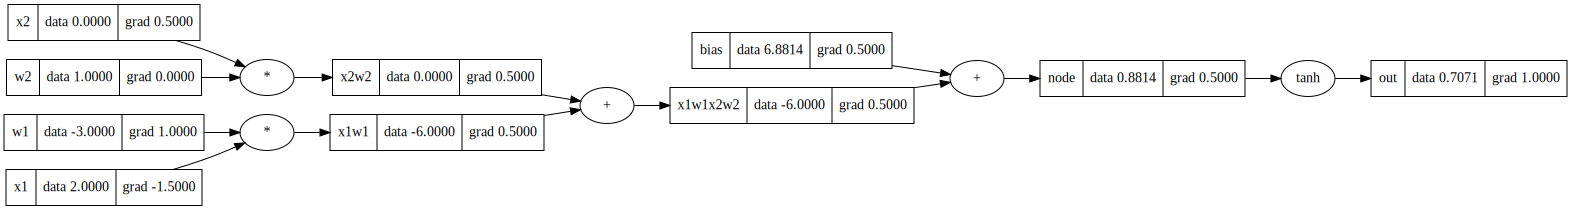

In [25]:


node._backward()
bias._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
# b._backward
draw_dot(out)

#### automate calling backwards in every step
instead of calling backwards for every variable, we've implemented a public backward function in the Value class that takes care of this.
To do this, we need to get a topologcal order of our Value variables

In [26]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(out)
topo       

[Value(data=-3.0, w1),
 Value(data=2.0, x1),
 Value(data=-6.0, x1w1),
 Value(data=0.0, x2),
 Value(data=1.0, w2),
 Value(data=0.0, x2w2),
 Value(data=-6.0, x1w1x2w2),
 Value(data=6.88137358, bias),
 Value(data=0.88137358, node),
 Value(data=0.707106777676776, out)]

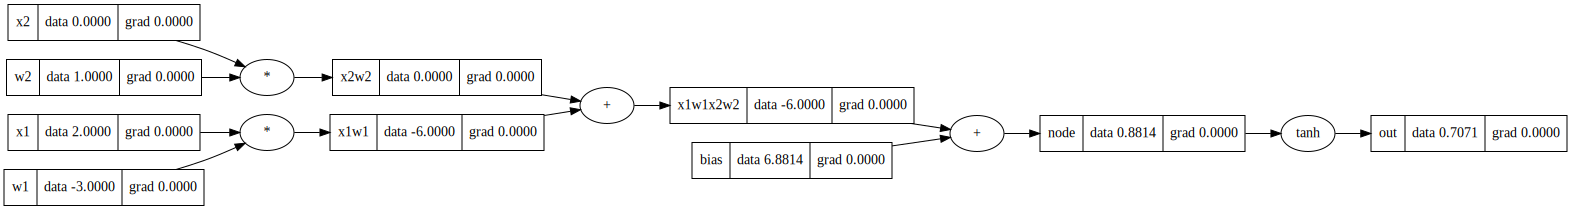

In [27]:
# redefine and calc backward
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
bias = Value(6.88137358, label='bias')
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label='x2w2' 
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
node = x1w1x2w2 + bias; node.label='node'
out = node.tanh(); out.label='out'
draw_dot(out)



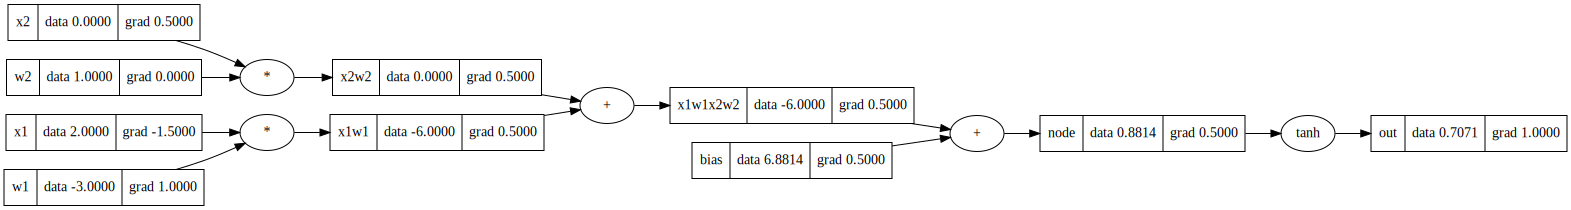

In [28]:

out.backward()
draw_dot(out)

### adding math operations to value class

In [29]:
a = Value(2.0)
b = Value(4.0)

In [30]:
a + 1

Value(data=3.0, )

In [31]:
1+a

Value(data=3.0, )

In [32]:
a / b

Value(data=0.5, )

### Doing the same in pytorch

In [33]:
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


### Build neural network

In [34]:
import random
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [35]:
x = [2.0, 3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=0.4549875439491463, )

In [36]:
n.sz

AttributeError: 'MLP' object has no attribute 'sz'

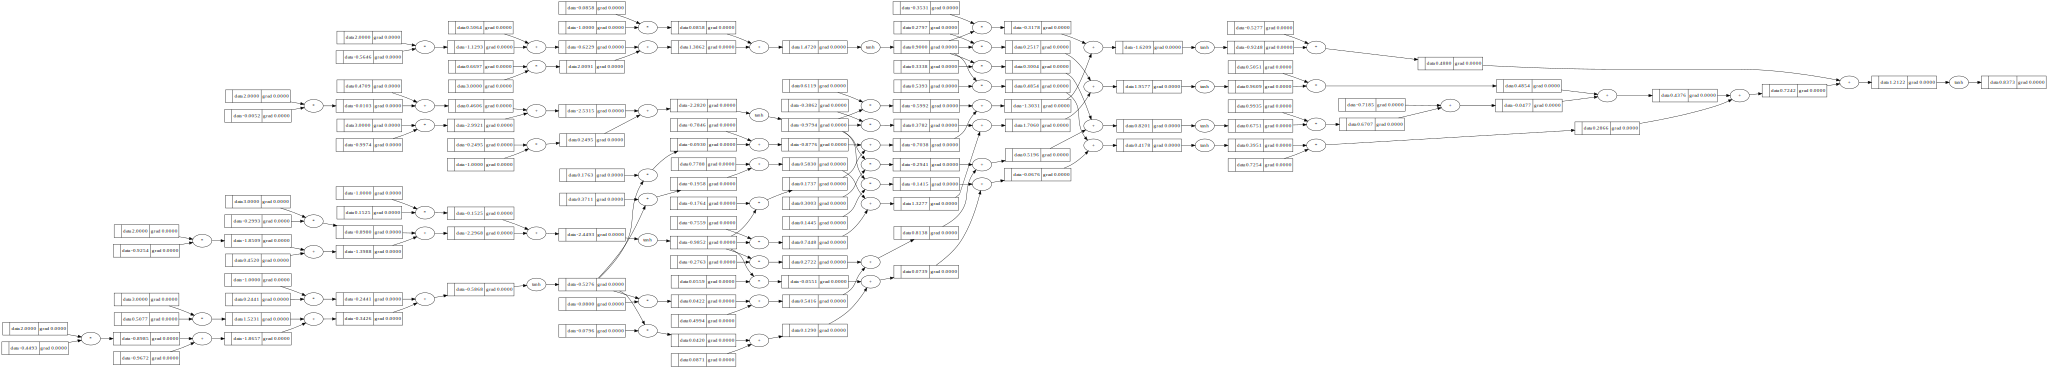

In [ ]:
draw_dot(n(x))

#### Exampel with loss function


In [37]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [42]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.4549875439491463, ),
 Value(data=0.3416206563814697, ),
 Value(data=0.28770484625077, ),
 Value(data=0.4549255368036434, )]

In [ ]:

for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)
  

0 4.008612057361247
1 2.919996522918143
2 3.164199732086423
3 1.2010620778836008
4 0.8840524471387824
5 0.4390784971564888
6 0.09276343711422314
7 0.06296177581740232
8 0.05033900405318091
9 0.04255275051326776
10 0.03705112764791441
11 0.03288183762852678
12 0.029583196375832253
13 0.02689497156125921
14 0.024655674159232248
15 0.02275824859616136
16 0.021128226038545157
17 0.01971186597730136
18 0.018469240176212345
19 0.017369969187442203



v

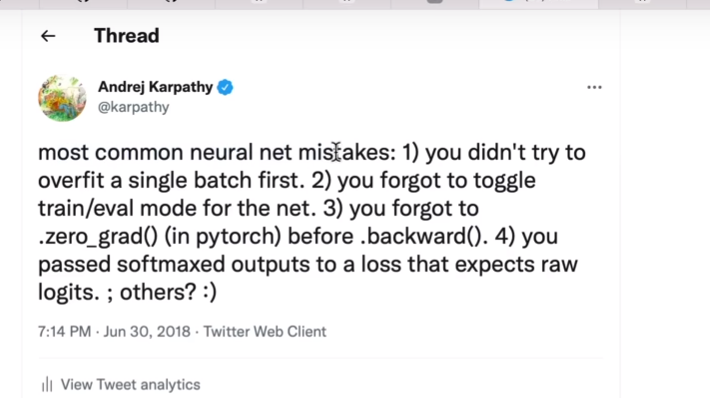

TODOs:
- write wraup up with:
    - key learnings
    - further todos
- init github repo and add notebook

# Wrap Up:
## Key Learnings:
- how derivates and nodes play together
- each weight has one gradient
- how the gradient is acutally calculated 
- how simple it is

## ToDos:
- to excerice: https://colab.research.google.com/drive/1FPTx1RXtBfc4MaTkf7viZZD4U2F9gtKN?usp=sharing
- code micrograd from scratch
- implement vae with micrograd 
    - show with that why reparametrization trick is necessary
- better write up key learnings